# Plotting refrigerant-ethanol viscosity data for RDD-2024 Poster

Data collected by Swetha Vutlapalli - 2023

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2023 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 27/04/2024
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib widget

In [2]:
# Where data are stored.
directory = "/Users/dduke/Desktop/Swetha/"
filename = "ViscosityDataSummayReport.xlsx"

In [42]:
# Error data. Taken manually from ViscosityDataSummayReport.xlsx
# The combined random error (from repeated trials and velocity uncertainty reported by SV) is relatively small.
# I took the maximum value for all mass fractions, the values are given for each theta.
mu_uncertainty={'R134a':(9.00E-05, 1.60E-04, 1.86E-05, 2.11E-04, 1.06E-04),\
              'R152a':(6.71123E-05, 0.000118954, 9.94575E-05, 2.40359E-05, 4.89571E-05),\
              'R1234ze':(2.01348E-05,4.34444E-05,6.08708E-05,2.25379E-05,2.21592E-06),\
              'theta':(8,10,15,20,25)}

In [84]:
# Read data
data = {}
print("Reading %s" % filename)
for sheet_name in pd.ExcelFile(directory+filename).sheet_names:
    if 'in Ethanol' in sheet_name:
        print("\timport '"+sheet_name+"'")
        df = pd.read_excel(directory+filename, sheet_name=sheet_name)
        comp = df['Composition']
        ethww = []; m=None
        for c in comp:
            if isinstance(c,str): m=float(c.strip('e'))
            ethww.append(m/100.)
        theta = np.array(df['Inclination angle'])
        mu = np.array(1e6*df['mu_corrected'])

        # Read associated pure substance deviations and map accordingly
        prop = sheet_name.split(' ')[0]
        df2 = pd.read_excel(directory+filename, sheet_name=prop)
        dev_th = np.array(df2['Inclination angle'])
        dev_mu = np.array(df2['mu_deviation(%)'])
        theta_indices = [ np.where(dev_th==t)[0][0] for t in theta ]
        eps_dev = np.array([ dev_mu[i] for i in theta_indices ]) * mu / 100.
        
        # Read uncertainty and map accordingly
        theta_indices = [ np.where(mu_uncertainty['theta']==t)[0][0] for t in theta ]
        eps_unc = np.array([ mu_uncertainty[prop][i] for i in theta_indices ])
        
        # Save result to dict.
        data[prop]=(np.array(ethww),np.array(theta),np.array(mu),np.array(eps_dev),np.array(eps_unc))

Reading ViscosityDataSummayReport.xlsx
	import 'R134a in Ethanol'
	import 'R152a in Ethanol'
	import 'R1234ze in Ethanol'


In [85]:
# Pure property data at same temperature. (292.88K)

#Huber, M.L.; Laesecke, A.; Perkins, R.A., Model for the Viscosity and Thermal Conductivity of Refrigerants,
# Including a New Correlation for the Viscosity of R134a, Ind. Eng. Chem. Res., 2003, 42, 13, 3163-3178, https://doi.org/10.1021/ie0300880 . [all data]
#The uncertainty in viscosity is 1.5% along the saturated liquid line, 3% in the liquid phase, 0.5% in the dilute gas, 
# 3-5% in the vapor phase, and 5% in the supercritical region, rising to 8% at pressures above 40 MPa. Below 200 K, the uncertainty is 8%.
R134a_mu = 208.06 # µPa-s

#Ian H. Bell and Arno Laesecke. Viscosity of refrigerants and other working fluids from residual entropy scaling .
# In 16th International Refrigeration and Air Conditioning Conference at Purdue, July 11-14, 2016. 2016.
R152a_mu = 173.31 # µPa-s
R1234_mu = 203.8 # µPa-s

#https://www.engineeringtoolbox.com/ethanol-dynamic-kinematic-viscosity-temperature-pressure-d_2071.html
Ethanol_mu = 1190 # µPa-s

pureProp={'R134a':R134a_mu, 'R152a':R152a_mu, 'R1234ze':R1234_mu}

In [86]:
# Thermophysical constants.
mwt_propellant = 102.03 #[g/mol]
mwt_ethanol = 46.068 #[g/mol]
omega_p = 0.32684 # acentric factor of propellant [-]
pc_p = 4059280.0 # critical pressure of propellant [Pa]
Tc_p = 374.21 # critical point temperature of propellant [K]

# From NIST Webbook.
purePropLiquidMolarVolume = lambda t: 2.2507E-09*t**2 - 1.0481E-06*t + 1.9679E-04 #R² = 9.9740E-01
ethanolLiquidMolarVolume = lambda t: 6.2775E-08*t + 3.9964E-05 #R² = 9.9982E-01

In [87]:
def mass_to_mole_fraction(m): return m/mwt_ethanol/((m/mwt_ethanol) + (1-m)/mwt_propellant)
def mole_to_mass_fraction(x): return x*mwt_ethanol/((x*mwt_ethanol) + (1-x)*mwt_propellant)
    
# Calculate ideal liquid mixture density
def rhoMix(massFracEth):
    x = mass_to_mole_fraction(massFracEth)
    Vprop = purePropLiquidMolarVolume(x) # m3/mol
    Veth  = ethanolLiquidMolarVolume(x) # m3/mol
    return (x * 1e-3*mwt_propellant / Vprop) + ((1-x) * 1e-3*mwt_ethanol / Veth) # kg/m3

## Plot all data vs ethanol mass fraction and fit cubic

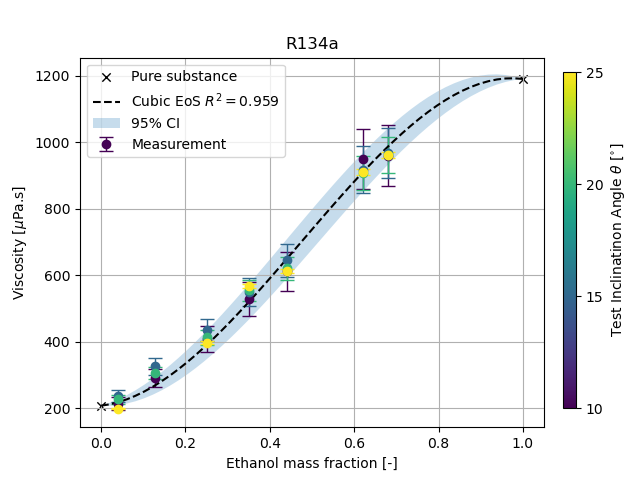

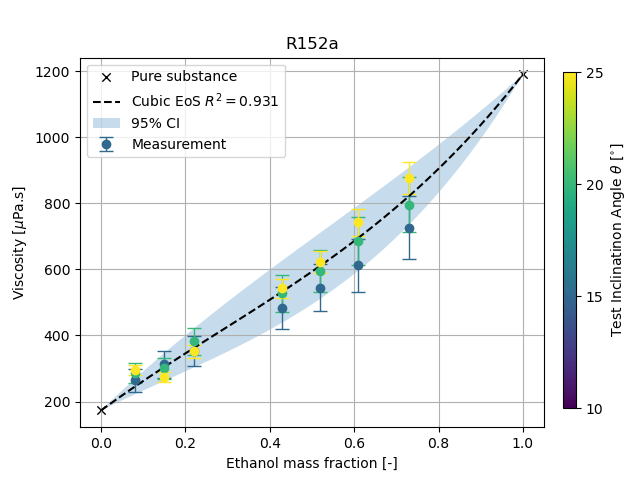

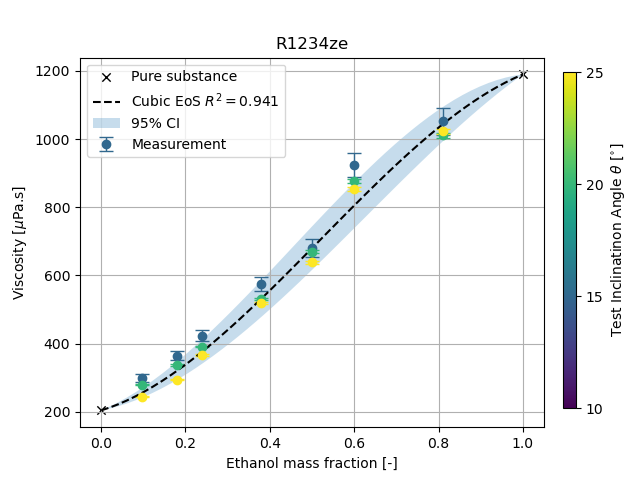

In [157]:
import scipy.optimize

def r2_nonlin(original_data, fitted):
    ss_err = np.sum((original_data-fitted)**2)
    ss_tot = np.sum(original_data**2)
    return 1-np.sqrt(ss_err/ss_tot)

fit_data={}
x_ = np.linspace(0,1,50)
ffit = lambda x,a,b,c,d: a*x**3 + b*x**2 + c*x + d

for d,ns,minTheta in zip(data,(6,2,12),(10,11,11)): # Loop propellants
    fig=plt.figure()

    #plt.scatter(data[d][0],data[d][2],c=data[d][1]/25.,cmap='jet')
    
    # Get errorbar
    eps = np.sqrt( data[d][3]**2 + data[d][4]**2 )

    # Sort data by the inclination angle and plot a unique color for each one.
    l='Measurement'
    for t in np.unique(theta):
        if t >= minTheta:
            i = np.where(data[d][1]==t)[0]
            cval = (data[d][1][i[0]]-10)/(25-10)
            plt.errorbar(data[d][0][i],data[d][2][i],yerr=eps[i],lw=1,ls='None',\
                         label=l,capsize=5,marker='o',c=plt.colormaps['viridis'](cval))
            l=None
    
    # Straight line mixing rule for pure substances @ same temp.
    plt.scatter([0, 1],[pureProp[d], Ethanol_mu],marker='x',c='k',lw=1,label="Pure substance") 

    # Fitted lines
    def make_fit(nsigma=0):
        i = np.where(data[d][1]>=minTheta)[0]
        t = np.hstack((0,data[d][0][i],1))
        m = np.hstack((pureProp[d],data[d][2][i],Ethanol_mu))
        s = np.hstack((1e-6,eps[i],1e-6))
        popt,pcov=scipy.optimize.curve_fit(ffit,t,m+s*nsigma,sigma=s)
        r2 = r2_nonlin(m, ffit(t, *popt))
        return popt,r2

    popt,r2 = make_fit()
    plt.plot(x_, ffit(x_,*popt), ls='--', c='k', label=r'Cubic EoS $R^2 = %.3f$' % r2)
    popt1,r2 = make_fit(ns); popt2,r2 = make_fit(-ns)
    plt.fill_between(x_, ffit(x_,*popt1), ffit(x_,*popt2), alpha=.25, label='95% CI')
    
    plt.title(d)
    plt.grid()
    plt.ylabel(r'Viscosity [$\mu$Pa.s]')
    plt.xlabel('Ethanol mass fraction [-]')
    plt.legend();
    
    plt.subplots_adjust(right=0.85)
    cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cb = mpl.colorbar.ColorbarBase(cax, cmap='viridis',norm=mpl.colors.Normalize(10, 25),\
                                   ticks=np.unique(data[d][1]))
    cb.set_label(r'Test Inclinatinon Angle $\theta$ [$^{\circ}$]');

    fit_data[d] = (popt,popt1,popt2)

## Make composite plot

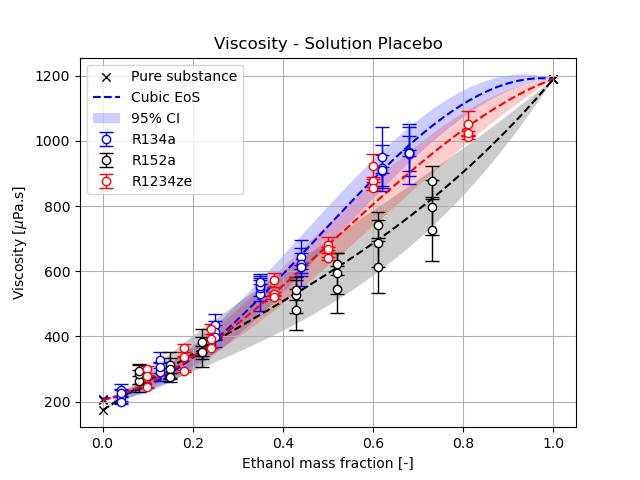

In [176]:
fig=plt.figure()

l=""
for d,c,minTheta in zip(data,('b','k','r'),(10,11,11)):

    # Filter data
    i = (data[d][1] >= minTheta)
    
    # Get errorbar
    eps = np.sqrt( data[d][3]**2 + data[d][4]**2 )

    plt.errorbar(data[d][0][i],data[d][2][i],yerr=eps[i],lw=1,ls='None',\
                 label=d,capsize=5,marker='o',c=c,mfc='w')
    
    
    # pure substances @ same temp.
    if l is not None: l="Pure substance"
    plt.scatter([0, 1],[pureProp[d], Ethanol_mu],marker='x',c='k',lw=1,label=l) 

    popt,popt1,popt2 = fit_data[d]

    if l is not None: l=r'Cubic EoS'
    plt.plot(x_, ffit(x_,*popt), ls='--', c=c, label=l)

    if l is not None: l=r'95% CI'
    plt.fill_between(x_, ffit(x_,*popt1), ffit(x_,*popt2), alpha=.2, label=l, color=c, edgecolor=None)

    l=None
    
plt.grid()
plt.ylabel(r'Viscosity [$\mu$Pa.s]')
plt.xlabel('Ethanol mass fraction [-]')

plt.legend();
plt.title("Viscosity - Solution Placebo");
plt.savefig("Viscosity.pdf");
    

## Fit data to the residual entropy scaling function

- Ian H. Bell and Arno Laesecke. Viscosity of refrigerants and other working fluids from residual entropy scaling. In 16th International Refrigeration and Air Conditioning Conference at Purdue, July 11-14, 2016. 2016.